In [5]:
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Dense,Embedding,RepeatVector,Bidirectional
from keras.models import Model
import re
import numpy as np
from scipy import stats
# import demoji
import tokenizer
from nltk.corpus import stopwords
stopwords_list = list(set(stopwords.words('english')))
from keras.utils import to_categorical


Using TensorFlow backend.


In [6]:
domain1_path = "./dEFEND/gossipcop_content_no_ignore.tsv"
domain2_path = "./dEFEND/politifact_content_no_ignore.tsv"

In [7]:
domain1_frame = pd.read_csv(domain1_path,delimiter="\t").set_index('id')
domain2_frame = pd.read_csv(domain2_path,delimiter="\t").set_index('id')

### Counts for each label for the 2 domain

#### First Domain

In [8]:
domain1_frame

,label,content
id,,
gossipcop-9096198130,1,Sarah Jessica Parker is getting candid about h...
gossipcop-6982710185,1,Many celebrities have been sharing their thoug...
gossipcop-7887456921,1,He reportedly hasn't seen her in over four yea...
gossipcop-1594778479,1,The fashion crowd is speaking out about Kim Ka...
gossipcop-8172018375,1,What term do you want to search? Search with g...
...,...,...
gossipcop-854842,0,Aisha Tyler‘s divorce from Jeffrey Tietjens ha...
gossipcop-843491,0,All four of Queen Elizabeth and Prince Philip'...
gossipcop-897778,0,Theresa Caputo is adjusting to her new life af...


In [9]:
domain1_frame.groupby(['label'])[['label']].count()

,label
label,
0,3586
1,2230


#### Second Domain

In [10]:
domain2_frame.groupby(['label'])[['label']].count()

,label
label,
0,145
1,270


### Cleaning the Text

In [11]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[()\"_#/@;*%:{}<>`+=~|.!?,'$-\[\]]", "", text)
    text = re.sub(r"[0-9]", "", text)
    
#     for words in stopwords_list:
#         text = re.sub(r"\b{}\b".format(words),"",text)
    
    return text

In [12]:
def tagger(decoder_input_sentence):
    start = "<BOS> "
    end = " <EOS>"
    final_target = [start + text + end for text in decoder_input_sentence] 
    return final_target

In [13]:
# def tokenizer(text_lists):
#     return [line.split(" ") for line in text_lists]

In [14]:
def create_vocab(text_lists):
    tokenizer = Tokenizer(oov_token="<UNK>")
    tokenizer.fit_on_texts(text_lists)
    
    dictionary = tokenizer.word_index
    word2idx = {}
    idx2word = {}
    for k,v in dictionary.items():
        word2idx[k]=v
        idx2word[v]=k
    
    return word2idx,idx2word,tokenizer

#### Encoder Training Data

In [73]:
encoder_inputs = domain1_frame['content'].apply(lambda x: clean_text(x)).values.tolist()+ domain2_frame['content'].apply(lambda x: clean_text(x)).values.tolist()
# encoder_inputs = 
decoder_inputs = tagger(encoder_inputs[:])

#### Fake news detection training data

In [74]:
X_CC = domain1_frame['content'].apply(lambda x: clean_text(x)).values.tolist()+ domain2_frame['content'].apply(lambda x: clean_text(x)).values.tolist()
Y_CC = np.array(domain1_frame['label'].apply(lambda x:int(x)).values.tolist()+ domain2_frame['label'].apply(lambda x:int(x)).values.tolist())
Y_CC_oh = to_categorical(Y_CC)

#### Domain classification Data

In [75]:
X_DC = domain1_frame['content'].apply(lambda x: clean_text(x)).values.tolist()+ domain2_frame['content'].apply(lambda x: clean_text(x)).values.tolist()
Y_DC = np.array([0]*len(domain1_frame) + [1]*len(domain2_frame))
Y_DC_oh = to_categorical(Y_DC)

In [82]:
idx = np.arange(len(encoder_inputs))
np.random.shuffle(idx)
encoder_inputs = np.array(encoder_inputs)[idx]
decodeer_inputs = np.array(decoder_inputs)[idx]
Y_CC = Y_CC[idx]
Y_DC = Y_DC[idx]
Y_CC_oh = Y_CC_oh[idx]
Y_DC_oh = Y_DC_oh[idx]

AttributeError: 'list' object has no attribute 'shape'

In [83]:
word2idx,idx2word,tokenizer = create_vocab(encoder_inputs)

### Due to ambiguity with regards to Keras Tokenizer num_words, below is a good enough fix, though it changes the tokenizer word_index outside of the class

In [84]:
num_words = 10000

sorted_by_word_count = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
tokenizer.word_index = {}
word2idx = {}
idx2word = {}
i = 0
for word,count in sorted_by_word_count:
    if i == num_words:
        break

    tokenizer.word_index[word] = i + 1    # <= because tokenizer is 1 indexed
    word2idx[word] = i+1
    idx2word[i+1]=word
    i += 1





In [85]:
tokenizer.word_index[tokenizer.oov_token] = num_words+1
word2idx[tokenizer.oov_token] = num_words+1
idx2word[num_words+1]=tokenizer.oov_token

In [577]:
# idx = len(tokenizer.word_index)+1
# tokenizer.word_index["<BOS>"] = idx
# word2idx["<BOS>"] = idx
# idx2word[idx] = "<BOS>"

# idx = len(tokenizer.word_index)+1
# tokenizer.word_index["<EOS>"] = idx
# word2idx["<EOS>"] = idx
# idx2word[idx] = "<EOS>"

In [86]:
word2idx["<UNK>"]

10001

In [87]:

t_encoder_inputs = tokenizer.texts_to_sequences(encoder_inputs)
t_decoder_inputs = tokenizer.texts_to_sequences(decoder_inputs)


# 
t_encoder_inputs = pad_sequences(t_encoder_inputs,maxlen=10,padding='post', truncating='post')

# t_decoder_inputs = pad_sequences(t_encoder_inputs,maxlen=100,padding='post', truncating='post')
# t_decoder_inputs = np.insert(t_decoder_inputs,0,word2idx["<BOS>"],axis=1)
# t_decoder_inputs = np.insert(t_decoder_inputs,t_decoder_inputs.shape[1],word2idx["<EOS>"],axis=1)


max_encoder_len = max([len(val) for val in t_encoder_inputs])
max_decoder_len = max([len(val) for val in t_decoder_inputs])


In [88]:
def test_generator(X,Y,Y_CC,Y_DC,batch_size=128,max_len=5):
    
        
    y_cc = to_categorical(Y_CC)
    y_dc = to_categorical(Y_DC)
    for idx in range(0,len(X),batch_size):

        encoder_input = np.zeros((batch_size,max_encoder_len))
#         decoder_input = np.zeros((batch_size,max_decoder_len))
        decoder_target = np.zeros((batch_size,max_encoder_len,len(word2idx)+1))
        for j,input_seq in enumerate(X[idx:idx+batch_size]):
            for i,word_idx in enumerate(input_seq):
                encoder_input[j,i]= word_idx
                decoder_target[j,i,word_idx] = 1
           
        yield [encoder_input,[decoder_target,y_cc[idx:idx+batch_size],y_dc[idx:idx+batch_size]]]

        

In [89]:
def all_data_generator(X,Y,Y_CC,Y_DC):
    encoder_input = np.zeros((len(X),max_encoder_len))
    decoder_input = np.zeros((len(X),max_decoder_len))
    decoder_target = np.zeros((len(X),max_encoder_len,len(word2idx)+1)) ## Extra index for padding, word2idx is 1 indexed
    for j,(input_seq,target_seq) in enumerate(zip(X,Y)):
        for i,word_idx in enumerate(input_seq):
            encoder_input[j,i]= word_idx
            decoder_target[j,i,word_idx] = 1
    
    y_cc = to_categorical(Y_CC)
    y_dc = to_categorical(Y_DC)

    return [encoder_input,[decoder_target,y_cc,y_dc]]

In [90]:
vocab_len= len(word2idx)

### Loading Glove Word Vectors

In [36]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [37]:
embedding_matrix = np.zeros((vocab_len+1, 100))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i+1] = embedding_vector

In [38]:
embedding_matrix.shape

(10002, 100)

### Building the Final model

In [91]:
inputs = Input(shape=(max_encoder_len,),name="encoder_inputs")

encoder_embedding = Embedding(vocab_len+1,100,trainable=True,input_length=max_encoder_len,mask_zero=True,name="encoder_embedding")

encoder_inputs = encoder_embedding(inputs)


encoder = LSTM(64,return_state=True)


encoder_outputs, state_h, state_c = encoder(encoder_inputs)


encoder_states = [state_h,state_c]


########## Content Classification Part ###############

fully_connected_CC = Dense(128,
                       activation="tanh",
                       name="non_linear_CC")

logits_CC = fully_connected_CC(encoder_outputs)

softmax_layer_CC = Dense(2,
                     activation="softmax",
                     name="softmax_layer_CC")

output_CC = softmax_layer_CC(logits_CC)


######### Domain Classification Part ##############

fully_connected_DC = Dense(128,
                       activation="tanh",
                       name="non_linear_DC")

logits_DC = fully_connected_DC(encoder_outputs)

softmax_layer_DC = Dense(2,
                     activation="softmax",
                     name="softmax_layer_DC")

output_DC = softmax_layer_DC(logits_DC)


########### Autoencoder PART #############
decoder_inputs = RepeatVector(max_encoder_len)(encoder_outputs)


decoder_lstm = LSTM(64, 
                         return_state=True,
                        return_sequences=True,
                         name = 'decoder_lstm')


decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)


decoder_dense = Dense(vocab_len+1, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)



model = Model(inputs,[decoder_outputs,output_CC,output_DC])
# model = Model(inputs,output_CC)

In [92]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 10, 100)      1000200     encoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 64), (None,  42240       encoder_embedding[0][0]          
__________________________________________________________________________________________________
repeat_vector_7 (RepeatVector)  (None, 10, 64)       0           lstm_7[0][0]                     
____________________________________________________________________________________________

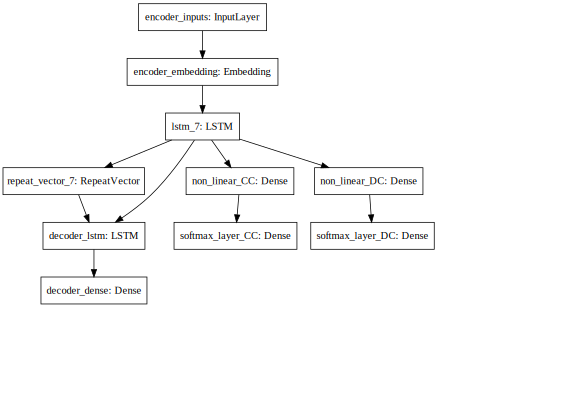

In [93]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [94]:
generator = test_generator(t_encoder_inputs,t_decoder_inputs,Y_CC,Y_DC,batch_size=len(t_encoder_inputs))
encoder_input_data,[decoder_target_data,y_cc,y_dc] = next(generator)

In [95]:
len(y_cc)

6231

In [96]:
model.compile(optimizer='rmsprop', loss=['categorical_crossentropy', 'binary_crossentropy', 'binary_crossentropy'],
             loss_weights=[0.1,0.6,-0.1],metrics=["accuracy"])
history = model.fit(encoder_input_data, 
                    [decoder_target_data,y_cc,y_dc],
                    batch_size=128,
                    validation_split=0.2,
#                     shuffle=True,
                    epochs=800)

/Users/arnav1712/Desktop/University_Stuff/SMM/Cross-Domain-Fake-News-Detection/venv/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4984 samples, validate on 1247 samples
Epoch 1/800
4984/4984 [==============================] - 41s 8ms/step - loss: 0.0801 - decoder_dense_loss: 7.8643 - softmax_layer_CC_loss: 0.6839 - softmax_layer_DC_loss: 11.1746 - decoder_dense_accuracy: 0.0702 - softmax_layer_CC_accuracy: 0.5925 - softmax_layer_DC_accuracy: 0.0732 - val_loss: -0.3182 - val_decoder_dense_loss: 6.9387 - val_softmax_layer_CC_loss: 0.6763 - val_softmax_layer_DC_loss: 14.1881 - val_decoder_dense_accuracy: 0.0719 - val_softmax_layer_CC_accuracy: 0.5710 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 2/800
4984/4984 [==============================] - 40s 8ms/step - loss: -0.3755 - decoder_dense_loss: 6.7737 - softmax_layer_CC_loss: 0.6425 - softmax_layer_DC_loss: 14.3839 - decoder_dense_accuracy: 0.0731 - softmax_layer_CC_accuracy: 0.6336 - softmax_layer_DC_accuracy: 0.0638 - val_loss: -0.3296 - val_decoder_dense_loss: 6.8159 - val_softmax_layer_CC_loss: 0.6790 - val_softmax_layer_DC_loss: 14.1919 - val_decoder_

4984/4984 [==============================] - 54s 11ms/step - loss: -0.7686 - decoder_dense_loss: 6.3930 - softmax_layer_CC_loss: 0.0528 - softmax_layer_DC_loss: 14.3954 - decoder_dense_accuracy: 0.0732 - softmax_layer_CC_accuracy: 0.9797 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.1540 - val_decoder_dense_loss: 6.7435 - val_softmax_layer_CC_loss: 1.4921 - val_softmax_layer_DC_loss: 14.1959 - val_decoder_dense_accuracy: 0.0719 - val_softmax_layer_CC_accuracy: 0.6616 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 17/800
4984/4984 [==============================] - 53s 11ms/step - loss: -0.7735 - decoder_dense_loss: 6.3717 - softmax_layer_CC_loss: 0.0485 - softmax_layer_DC_loss: 14.3976 - decoder_dense_accuracy: 0.0732 - softmax_layer_CC_accuracy: 0.9841 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.3011 - val_decoder_dense_loss: 6.7302 - val_softmax_layer_CC_loss: 1.7430 - val_softmax_layer_DC_loss: 14.1954 - val_decoder_dense_accuracy: 0.0721 - val_softmax_layer_CC_accuracy: 0.

4984/4984 [==============================] - 25s 5ms/step - loss: -0.8167 - decoder_dense_loss: 6.0571 - softmax_layer_CC_loss: 0.0290 - softmax_layer_DC_loss: 14.3986 - decoder_dense_accuracy: 0.0836 - softmax_layer_CC_accuracy: 0.9888 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.2880 - val_decoder_dense_loss: 6.6577 - val_softmax_layer_CC_loss: 1.7257 - val_softmax_layer_DC_loss: 14.1740 - val_decoder_dense_accuracy: 0.0798 - val_softmax_layer_CC_accuracy: 0.6728 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 32/800
4984/4984 [==============================] - 26s 5ms/step - loss: -0.8201 - decoder_dense_loss: 6.0342 - softmax_layer_CC_loss: 0.0270 - softmax_layer_DC_loss: 14.3967 - decoder_dense_accuracy: 0.0851 - softmax_layer_CC_accuracy: 0.9890 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.2572 - val_decoder_dense_loss: 6.6552 - val_softmax_layer_CC_loss: 1.6742 - val_softmax_layer_DC_loss: 14.1643 - val_decoder_dense_accuracy: 0.0791 - val_softmax_layer_CC_accuracy: 0.66

Epoch 47/800
4984/4984 [==============================] - 27s 5ms/step - loss: -0.8617 - decoder_dense_loss: 5.6459 - softmax_layer_CC_loss: 0.0225 - softmax_layer_DC_loss: 14.3976 - decoder_dense_accuracy: 0.1153 - softmax_layer_CC_accuracy: 0.9886 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.3951 - val_decoder_dense_loss: 6.5392 - val_softmax_layer_CC_loss: 1.9241 - val_softmax_layer_DC_loss: 14.1704 - val_decoder_dense_accuracy: 0.1026 - val_softmax_layer_CC_accuracy: 0.6552 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 48/800
4984/4984 [==============================] - 26s 5ms/step - loss: -0.8664 - decoder_dense_loss: 5.6141 - softmax_layer_CC_loss: 0.0199 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.1184 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.4494 - val_decoder_dense_loss: 6.5312 - val_softmax_layer_CC_loss: 2.0138 - val_softmax_layer_DC_loss: 14.1673 - val_decoder_dense_accuracy: 0.1025 - val_softmax_layer_CC_a

4984/4984 [==============================] - 27s 5ms/step - loss: -0.9086 - decoder_dense_loss: 5.1898 - softmax_layer_CC_loss: 0.0204 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.1526 - softmax_layer_CC_accuracy: 0.9896 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.5938 - val_decoder_dense_loss: 6.3716 - val_softmax_layer_CC_loss: 2.2866 - val_softmax_layer_DC_loss: 14.1616 - val_decoder_dense_accuracy: 0.1246 - val_softmax_layer_CC_accuracy: 0.6536 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 63/800
4984/4984 [==============================] - 30s 6ms/step - loss: -0.9128 - decoder_dense_loss: 5.1544 - softmax_layer_CC_loss: 0.0193 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.1572 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.5058 - val_decoder_dense_loss: 6.3684 - val_softmax_layer_CC_loss: 2.1379 - val_softmax_layer_DC_loss: 14.1551 - val_decoder_dense_accuracy: 0.1241 - val_softmax_layer_CC_accuracy: 0.65

Epoch 78/800
4984/4984 [==============================] - 29s 6ms/step - loss: -0.9562 - decoder_dense_loss: 4.7177 - softmax_layer_CC_loss: 0.0197 - softmax_layer_DC_loss: 14.3976 - decoder_dense_accuracy: 0.1915 - softmax_layer_CC_accuracy: 0.9888 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.6190 - val_decoder_dense_loss: 6.2241 - val_softmax_layer_CC_loss: 2.3517 - val_softmax_layer_DC_loss: 14.1541 - val_decoder_dense_accuracy: 0.1403 - val_softmax_layer_CC_accuracy: 0.6496 - val_softmax_layer_DC_accuracy: 0.0786
Epoch 79/800
4984/4984 [==============================] - 29s 6ms/step - loss: -0.9603 - decoder_dense_loss: 4.6882 - softmax_layer_CC_loss: 0.0179 - softmax_layer_DC_loss: 14.3972 - decoder_dense_accuracy: 0.1914 - softmax_layer_CC_accuracy: 0.9904 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.6558 - val_decoder_dense_loss: 6.2188 - val_softmax_layer_CC_loss: 2.4146 - val_softmax_layer_DC_loss: 14.1608 - val_decoder_dense_accuracy: 0.1409 - val_softmax_layer_CC_a

4984/4984 [==============================] - 40s 8ms/step - loss: -0.9969 - decoder_dense_loss: 4.3231 - softmax_layer_CC_loss: 0.0176 - softmax_layer_DC_loss: 14.3982 - decoder_dense_accuracy: 0.2229 - softmax_layer_CC_accuracy: 0.9896 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.6573 - val_decoder_dense_loss: 6.1485 - val_softmax_layer_CC_loss: 2.4275 - val_softmax_layer_DC_loss: 14.1350 - val_decoder_dense_accuracy: 0.1522 - val_softmax_layer_CC_accuracy: 0.6488 - val_softmax_layer_DC_accuracy: 0.0786
Epoch 94/800
4984/4984 [==============================] - 36s 7ms/step - loss: -0.9986 - decoder_dense_loss: 4.3037 - softmax_layer_CC_loss: 0.0180 - softmax_layer_DC_loss: 14.3974 - decoder_dense_accuracy: 0.2254 - softmax_layer_CC_accuracy: 0.9904 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.7536 - val_decoder_dense_loss: 6.1472 - val_softmax_layer_CC_loss: 2.5899 - val_softmax_layer_DC_loss: 14.1419 - val_decoder_dense_accuracy: 0.1518 - val_softmax_layer_CC_accuracy: 0.65

4984/4984 [==============================] - 32s 6ms/step - loss: -1.0324 - decoder_dense_loss: 3.9673 - softmax_layer_CC_loss: 0.0178 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.2580 - softmax_layer_CC_accuracy: 0.9894 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.7592 - val_decoder_dense_loss: 6.0998 - val_softmax_layer_CC_loss: 2.6083 - val_softmax_layer_DC_loss: 14.1478 - val_decoder_dense_accuracy: 0.1621 - val_softmax_layer_CC_accuracy: 0.6632 - val_softmax_layer_DC_accuracy: 0.0786
Epoch 109/800
4984/4984 [==============================] - 27s 5ms/step - loss: -1.0353 - decoder_dense_loss: 3.9388 - softmax_layer_CC_loss: 0.0177 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.2602 - softmax_layer_CC_accuracy: 0.9902 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.7931 - val_decoder_dense_loss: 6.0966 - val_softmax_layer_CC_loss: 2.6617 - val_softmax_layer_DC_loss: 14.1492 - val_decoder_dense_accuracy: 0.1622 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 26s 5ms/step - loss: -1.0658 - decoder_dense_loss: 3.6391 - softmax_layer_CC_loss: 0.0169 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.2914 - softmax_layer_CC_accuracy: 0.9916 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.7502 - val_decoder_dense_loss: 6.0745 - val_softmax_layer_CC_loss: 2.5940 - val_softmax_layer_DC_loss: 14.1556 - val_decoder_dense_accuracy: 0.1707 - val_softmax_layer_CC_accuracy: 0.6632 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 124/800
4984/4984 [==============================] - 27s 5ms/step - loss: -1.0681 - decoder_dense_loss: 3.6140 - softmax_layer_CC_loss: 0.0171 - softmax_layer_DC_loss: 14.3976 - decoder_dense_accuracy: 0.2945 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.6867 - val_decoder_dense_loss: 6.0850 - val_softmax_layer_CC_loss: 2.4840 - val_softmax_layer_DC_loss: 14.1409 - val_decoder_dense_accuracy: 0.1682 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 28s 6ms/step - loss: -1.0970 - decoder_dense_loss: 3.3282 - softmax_layer_CC_loss: 0.0166 - softmax_layer_DC_loss: 14.3982 - decoder_dense_accuracy: 0.3290 - softmax_layer_CC_accuracy: 0.9894 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8196 - val_decoder_dense_loss: 6.0938 - val_softmax_layer_CC_loss: 2.7062 - val_softmax_layer_DC_loss: 14.1495 - val_decoder_dense_accuracy: 0.1734 - val_softmax_layer_CC_accuracy: 0.6656 - val_softmax_layer_DC_accuracy: 0.0794
Epoch 139/800
4984/4984 [==============================] - 27s 5ms/step - loss: -1.0982 - decoder_dense_loss: 3.3153 - softmax_layer_CC_loss: 0.0167 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.3288 - softmax_layer_CC_accuracy: 0.9900 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.7885 - val_decoder_dense_loss: 6.0894 - val_softmax_layer_CC_loss: 2.6562 - val_softmax_layer_DC_loss: 14.1487 - val_decoder_dense_accuracy: 0.1767 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 28s 6ms/step - loss: -1.1234 - decoder_dense_loss: 3.0595 - softmax_layer_CC_loss: 0.0173 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.3641 - softmax_layer_CC_accuracy: 0.9906 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8411 - val_decoder_dense_loss: 6.1176 - val_softmax_layer_CC_loss: 2.7360 - val_softmax_layer_DC_loss: 14.1496 - val_decoder_dense_accuracy: 0.1776 - val_softmax_layer_CC_accuracy: 0.6576 - val_softmax_layer_DC_accuracy: 0.0794
Epoch 154/800
4984/4984 [==============================] - 31s 6ms/step - loss: -1.1257 - decoder_dense_loss: 3.0404 - softmax_layer_CC_loss: 0.0168 - softmax_layer_DC_loss: 14.3984 - decoder_dense_accuracy: 0.3672 - softmax_layer_CC_accuracy: 0.9914 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8035 - val_decoder_dense_loss: 6.1181 - val_softmax_layer_CC_loss: 2.6753 - val_softmax_layer_DC_loss: 14.1470 - val_decoder_dense_accuracy: 0.1774 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 32s 7ms/step - loss: -1.1491 - decoder_dense_loss: 2.8075 - softmax_layer_CC_loss: 0.0166 - softmax_layer_DC_loss: 14.3976 - decoder_dense_accuracy: 0.4017 - softmax_layer_CC_accuracy: 0.9904 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8539 - val_decoder_dense_loss: 6.1512 - val_softmax_layer_CC_loss: 2.7566 - val_softmax_layer_DC_loss: 14.1558 - val_decoder_dense_accuracy: 0.1807 - val_softmax_layer_CC_accuracy: 0.6528 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 169/800
4984/4984 [==============================] - 29s 6ms/step - loss: -1.1507 - decoder_dense_loss: 2.7925 - softmax_layer_CC_loss: 0.0165 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.4036 - softmax_layer_CC_accuracy: 0.9902 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8348 - val_decoder_dense_loss: 6.1448 - val_softmax_layer_CC_loss: 2.7226 - val_softmax_layer_DC_loss: 14.1598 - val_decoder_dense_accuracy: 0.1817 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 26s 5ms/step - loss: -1.1713 - decoder_dense_loss: 2.5878 - softmax_layer_CC_loss: 0.0163 - softmax_layer_DC_loss: 14.3974 - decoder_dense_accuracy: 0.4369 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9291 - val_decoder_dense_loss: 6.1807 - val_softmax_layer_CC_loss: 2.8796 - val_softmax_layer_DC_loss: 14.1734 - val_decoder_dense_accuracy: 0.1824 - val_softmax_layer_CC_accuracy: 0.6520 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 184/800
4984/4984 [==============================] - 26s 5ms/step - loss: -1.1731 - decoder_dense_loss: 2.5691 - softmax_layer_CC_loss: 0.0164 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.4411 - softmax_layer_CC_accuracy: 0.9904 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8370 - val_decoder_dense_loss: 6.2014 - val_softmax_layer_CC_loss: 2.7186 - val_softmax_layer_DC_loss: 14.1650 - val_decoder_dense_accuracy: 0.1807 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 29s 6ms/step - loss: -1.1920 - decoder_dense_loss: 2.3823 - softmax_layer_CC_loss: 0.0159 - softmax_layer_DC_loss: 14.3974 - decoder_dense_accuracy: 0.4730 - softmax_layer_CC_accuracy: 0.9916 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9302 - val_decoder_dense_loss: 6.2535 - val_softmax_layer_CC_loss: 2.8661 - val_softmax_layer_DC_loss: 14.1688 - val_decoder_dense_accuracy: 0.1839 - val_softmax_layer_CC_accuracy: 0.6544 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 199/800
4984/4984 [==============================] - 27s 5ms/step - loss: -1.1931 - decoder_dense_loss: 2.3695 - softmax_layer_CC_loss: 0.0163 - softmax_layer_DC_loss: 14.3992 - decoder_dense_accuracy: 0.4767 - softmax_layer_CC_accuracy: 0.9902 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9401 - val_decoder_dense_loss: 6.2532 - val_softmax_layer_CC_loss: 2.8837 - val_softmax_layer_DC_loss: 14.1769 - val_decoder_dense_accuracy: 0.1820 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 29s 6ms/step - loss: -1.2102 - decoder_dense_loss: 2.2019 - softmax_layer_CC_loss: 0.0158 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.5090 - softmax_layer_CC_accuracy: 0.9908 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9286 - val_decoder_dense_loss: 6.3182 - val_softmax_layer_CC_loss: 2.8531 - val_softmax_layer_DC_loss: 14.1781 - val_decoder_dense_accuracy: 0.1849 - val_softmax_layer_CC_accuracy: 0.6520 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 214/800
4984/4984 [==============================] - 29s 6ms/step - loss: -1.2113 - decoder_dense_loss: 2.1890 - softmax_layer_CC_loss: 0.0160 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.5113 - softmax_layer_CC_accuracy: 0.9900 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9386 - val_decoder_dense_loss: 6.3219 - val_softmax_layer_CC_loss: 2.8709 - val_softmax_layer_DC_loss: 14.1762 - val_decoder_dense_accuracy: 0.1834 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 39s 8ms/step - loss: -1.2264 - decoder_dense_loss: 2.0382 - softmax_layer_CC_loss: 0.0159 - softmax_layer_DC_loss: 14.3988 - decoder_dense_accuracy: 0.5426 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8976 - val_decoder_dense_loss: 6.3733 - val_softmax_layer_CC_loss: 2.7997 - val_softmax_layer_DC_loss: 14.1809 - val_decoder_dense_accuracy: 0.1879 - val_softmax_layer_CC_accuracy: 0.6528 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 229/800
4984/4984 [==============================] - 38s 8ms/step - loss: -1.2275 - decoder_dense_loss: 2.0273 - softmax_layer_CC_loss: 0.0159 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.5445 - softmax_layer_CC_accuracy: 0.9910 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9502 - val_decoder_dense_loss: 6.3977 - val_softmax_layer_CC_loss: 2.8794 - val_softmax_layer_DC_loss: 14.1821 - val_decoder_dense_accuracy: 0.1860 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 28s 6ms/step - loss: -1.2418 - decoder_dense_loss: 1.8858 - softmax_layer_CC_loss: 0.0156 - softmax_layer_DC_loss: 14.3974 - decoder_dense_accuracy: 0.5750 - softmax_layer_CC_accuracy: 0.9910 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9376 - val_decoder_dense_loss: 6.4780 - val_softmax_layer_CC_loss: 2.8434 - val_softmax_layer_DC_loss: 14.1767 - val_decoder_dense_accuracy: 0.1894 - val_softmax_layer_CC_accuracy: 0.6520 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 244/800
4984/4984 [==============================] - 28s 6ms/step - loss: -1.2426 - decoder_dense_loss: 1.8763 - softmax_layer_CC_loss: 0.0159 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.5773 - softmax_layer_CC_accuracy: 0.9900 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9207 - val_decoder_dense_loss: 6.4863 - val_softmax_layer_CC_loss: 2.8102 - val_softmax_layer_DC_loss: 14.1774 - val_decoder_dense_accuracy: 0.1882 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 27s 5ms/step - loss: -1.2550 - decoder_dense_loss: 1.7540 - softmax_layer_CC_loss: 0.0157 - softmax_layer_DC_loss: 14.3980 - decoder_dense_accuracy: 0.6037 - softmax_layer_CC_accuracy: 0.9908 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.8933 - val_decoder_dense_loss: 6.5683 - val_softmax_layer_CC_loss: 2.7527 - val_softmax_layer_DC_loss: 14.1782 - val_decoder_dense_accuracy: 0.1872 - val_softmax_layer_CC_accuracy: 0.6536 - val_softmax_layer_DC_accuracy: 0.0770
Epoch 259/800
4984/4984 [==============================] - 28s 6ms/step - loss: -1.2556 - decoder_dense_loss: 1.7477 - softmax_layer_CC_loss: 0.0156 - softmax_layer_DC_loss: 14.3984 - decoder_dense_accuracy: 0.6054 - softmax_layer_CC_accuracy: 0.9904 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9277 - val_decoder_dense_loss: 6.5578 - val_softmax_layer_CC_loss: 2.8141 - val_softmax_layer_DC_loss: 14.1797 - val_decoder_dense_accuracy: 0.1877 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 29s 6ms/step - loss: -1.2674 - decoder_dense_loss: 1.6298 - softmax_layer_CC_loss: 0.0156 - softmax_layer_DC_loss: 14.3982 - decoder_dense_accuracy: 0.6344 - softmax_layer_CC_accuracy: 0.9910 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9632 - val_decoder_dense_loss: 6.6325 - val_softmax_layer_CC_loss: 2.8629 - val_softmax_layer_DC_loss: 14.1826 - val_decoder_dense_accuracy: 0.1889 - val_softmax_layer_CC_accuracy: 0.6464 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 274/800
4984/4984 [==============================] - 36s 7ms/step - loss: -1.2686 - decoder_dense_loss: 1.6171 - softmax_layer_CC_loss: 0.0158 - softmax_layer_DC_loss: 14.3976 - decoder_dense_accuracy: 0.6354 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9531 - val_decoder_dense_loss: 6.6387 - val_softmax_layer_CC_loss: 2.8436 - val_softmax_layer_DC_loss: 14.1821 - val_decoder_dense_accuracy: 0.1868 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 32s 6ms/step - loss: -1.2792 - decoder_dense_loss: 1.5135 - softmax_layer_CC_loss: 0.0155 - softmax_layer_DC_loss: 14.3982 - decoder_dense_accuracy: 0.6611 - softmax_layer_CC_accuracy: 0.9910 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9484 - val_decoder_dense_loss: 6.7276 - val_softmax_layer_CC_loss: 2.8203 - val_softmax_layer_DC_loss: 14.1804 - val_decoder_dense_accuracy: 0.1865 - val_softmax_layer_CC_accuracy: 0.6536 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 289/800
4984/4984 [==============================] - 30s 6ms/step - loss: -1.2794 - decoder_dense_loss: 1.5103 - softmax_layer_CC_loss: 0.0156 - softmax_layer_DC_loss: 14.3972 - decoder_dense_accuracy: 0.6605 - softmax_layer_CC_accuracy: 0.9900 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9375 - val_decoder_dense_loss: 6.7167 - val_softmax_layer_CC_loss: 2.8038 - val_softmax_layer_DC_loss: 14.1797 - val_decoder_dense_accuracy: 0.1885 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 28s 6ms/step - loss: -1.2894 - decoder_dense_loss: 1.4112 - softmax_layer_CC_loss: 0.0154 - softmax_layer_DC_loss: 14.3972 - decoder_dense_accuracy: 0.6832 - softmax_layer_CC_accuracy: 0.9898 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9815 - val_decoder_dense_loss: 6.7936 - val_softmax_layer_CC_loss: 2.8653 - val_softmax_layer_DC_loss: 14.1764 - val_decoder_dense_accuracy: 0.1905 - val_softmax_layer_CC_accuracy: 0.6512 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 304/800
4984/4984 [==============================] - 28s 6ms/step - loss: -1.2902 - decoder_dense_loss: 1.4028 - softmax_layer_CC_loss: 0.0155 - softmax_layer_DC_loss: 14.3978 - decoder_dense_accuracy: 0.6879 - softmax_layer_CC_accuracy: 0.9896 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9801 - val_decoder_dense_loss: 6.7843 - val_softmax_layer_CC_loss: 2.8641 - val_softmax_layer_DC_loss: 14.1843 - val_decoder_dense_accuracy: 0.1899 - val_softmax_layer_CC_accuracy: 0.6

4984/4984 [==============================] - 29s 6ms/step - loss: -1.2984 - decoder_dense_loss: 1.3210 - softmax_layer_CC_loss: 0.0155 - softmax_layer_DC_loss: 14.3984 - decoder_dense_accuracy: 0.7062 - softmax_layer_CC_accuracy: 0.9906 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 0.9864 - val_decoder_dense_loss: 6.8822 - val_softmax_layer_CC_loss: 2.8573 - val_softmax_layer_DC_loss: 14.1837 - val_decoder_dense_accuracy: 0.1893 - val_softmax_layer_CC_accuracy: 0.6520 - val_softmax_layer_DC_accuracy: 0.0778
Epoch 319/800
4984/4984 [==============================] - 28s 6ms/step - loss: -1.2993 - decoder_dense_loss: 1.3134 - softmax_layer_CC_loss: 0.0153 - softmax_layer_DC_loss: 14.3974 - decoder_dense_accuracy: 0.7100 - softmax_layer_CC_accuracy: 0.9902 - softmax_layer_DC_accuracy: 0.0638 - val_loss: 1.0033 - val_decoder_dense_loss: 6.9024 - val_softmax_layer_CC_loss: 2.8808 - val_softmax_layer_DC_loss: 14.1807 - val_decoder_dense_accuracy: 0.1899 - val_softmax_layer_CC_accuracy: 0.6

KeyboardInterrupt: 

### Building the Autoencoder

In [261]:
inputs = Input(shape=(max_encoder_len,),name="encoder_inputs")

encoder_embedding = Embedding(vocab_len+1,100,trainable=True,weights=[embedding_matrix],input_length=max_encoder_len,mask_zero=True,name="encoder_embedding")

encoder_inputs = encoder_embedding(inputs)

# encoder_inputs = LSTM(64,return_sequences=True)(encoder_inputs)
encoder = LSTM(64,return_state=True)

# encoder = Bidirectional(LSTM(64, 
#                     return_state=True, 
#                     name = 'encoder'))

# encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# # We discard `encoder_outputs` and only keep the states.

# encoder_states = [forward_h, backward_h]
encoder_states = [state_h,state_c]

# # Set up the decoder, using `encoder_states` as initial state.



decoder_inputs = RepeatVector(max_encoder_len)(encoder_outputs)

# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the
# # return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(64, 
                         return_state=True,
                        return_sequences=True,
                         name = 'decoder_lstm')


# # The inital_state call argument, specifying the initial state(s) of a RNN. 
# # This is used to pass the encoder states to the decoder as initial states.
# # Basically making the first memory of the decoder the encoded semantics
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
# decoder_outputs = LSTM(128,return_sequences=True)(decoder_outputs)

# decoder_outputs = Dense(64,activation="tanh")(decoder_outputs)
decoder_dense = Dense(vocab_len+1, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model(inputs,decoder_outputs)

In [262]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, 10)           0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 10, 100)      1000200     encoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 64), (None,  42240       encoder_embedding[0][0]          
__________________________________________________________________________________________________
repeat_vector_11 (RepeatVector) (None, 10, 64)       0           lstm_13[0][0]                    
___________________________________________________________________________________________

In [100]:
generator = test_generator(t_encoder_inputs,t_decoder_inputs,Y_CC,Y_DC,batch_size=150)

In [101]:
# [encoder_input_data,decoder_input_data],decoder_target_data = next(generator)
test_encoder_input_data,[test_decoder_target_data,test_y_cc,test_y_dc] = next(generator)

In [265]:
encoder_input_data,decoder_target_data = all_data_generator(t_encoder_inputs,t_decoder_inputs)

In [102]:
test_encoder_input_data.shape

(150, 10)

In [103]:
encoder_input_data[127]

array([4.3000e+01, 1.6000e+01, 4.1100e+02, 3.0000e+00, 4.3600e+02,
       7.1000e+01, 4.1000e+01, 1.0001e+04, 1.2000e+01, 1.5460e+03])

In [271]:
# [encoder_input_data,decoder_input_data],decoder_target_data = all_data_generator(t_encoder_inputs,t_decoder_inputs)
# encoder_input_data,decoder_target_data = all_data_generator(t_encoder_inputs,t_decoder_inputs)

In [775]:
# decoder_target_data.shape

### Training the Model

In [272]:
encoder_input_data[0]

array([ 952., 1064., 2305.,    8.,  269., 4031.,   35.,   13.,  136.,
         12.])

In [274]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit(encoder_input_data, 
                    decoder_target_data,
                    batch_size=128,
                    epochs=800)
#                     validation_split=0.2)

/Users/arnav1712/Desktop/University_Stuff/SMM/Cross-Domain-Fake-News-Detection/venv/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/800
128/128 [==============================] - 1s 11ms/step - loss: 5.5762
Epoch 2/800
128/128 [==============================] - 1s 4ms/step - loss: 5.6231
Epoch 3/800
128/128 [==============================] - 1s 4ms/step - loss: 5.4759
Epoch 4/800
128/128 [==============================] - 1s 4ms/step - loss: 5.4262
Epoch 5/800
128/128 [==============================] - 1s 4ms/step - loss: 5.3857
Epoch 6/800
128/128 [==============================] - 1s 4ms/step - loss: 5.3516
Epoch 7/800
128/128 [==============================] - 1s 4ms/step - loss: 5.3192
Epoch 8/800
128/128 [==============================] - 1s 4ms/step - loss: 5.2938
Epoch 9/800
128/128 [==============================] - 1s 5ms/step - loss: 5.2795
Epoch 10/800
128/128 [==============================] - 1s 4ms/step - loss: 5.2769
Epoch 11/800
128/128 [==============================] - 1s 5ms/step - loss: 5.2260
Epoch 12/800
128/128 [==============================] - 1s 4ms/step - loss: 5.1987
Epoch 13/800

Epoch 100/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6748
Epoch 101/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6589
Epoch 102/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6480
Epoch 103/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6429
Epoch 104/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6365
Epoch 105/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6311
Epoch 106/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6160
Epoch 107/800
128/128 [==============================] - 1s 4ms/step - loss: 3.6111
Epoch 108/800
128/128 [==============================] - 1s 5ms/step - loss: 3.5937
Epoch 109/800
128/128 [==============================] - 1s 5ms/step - loss: 3.5853
Epoch 110/800
128/128 [==============================] - 1s 5ms/step - loss: 3.5583
Epoch 111/800
128/128 [==============================] - 1s 5ms/step - loss:

Epoch 198/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5789
Epoch 199/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5534
Epoch 200/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5274
Epoch 201/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5099
Epoch 202/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5082
Epoch 203/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5279
Epoch 204/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5599
Epoch 205/800
128/128 [==============================] - 1s 4ms/step - loss: 2.5306
Epoch 206/800
128/128 [==============================] - 1s 4ms/step - loss: 2.4918
Epoch 207/800
128/128 [==============================] - 1s 4ms/step - loss: 2.4672
Epoch 208/800
128/128 [==============================] - 1s 4ms/step - loss: 2.4654
Epoch 209/800
128/128 [==============================] - 1s 4ms/step - loss:

KeyboardInterrupt: 

### Testing the Model

In [122]:
for idx in test_encoder_input_data[100]:
    print(idx2word[idx],end=" ")

loading the player who’s who in pippa middletongs young bridal 

In [108]:
# model.compile('rmsprop', 'mse')
output_array = model.predict([test_encoder_input_data])

In [116]:
for idx in output_array[0][28]:
    lookup = np.argmax(idx)
#     print(lookup)
    if lookup==0:
        break
    else:
        print(idx2word[lookup],end=" ")

kim said decided decided to a a a a a 

In [187]:
for idx in output_array[100]:
    print(idx[np.argmax(20)])
    break
    lookup = np.argmax(idx)
#     print(lookup)
    if lookup==0:
        break
    else:
        print(idx2word[lookup],end=" ")

1.9437695e-07
